In [1]:
import sys
import os
from pathlib import Path

# print(sys.executable)

# data_path= Path("/home/mehrzad/repos/beslog/1stpaper-ifcner/data")
# display(os.listdir(data_path ))


In [2]:
import pandas as pd

df=pd.read_csv(data_path / 'ifcner-paper-data-revised.csv')
df

,token,tag
0,highlight,O
1,all,B_quantity
2,slab,B_built_obj
3,highlight all slab,sentence
4,pick,O
...,...,...
23631,modeled,O
23632,within,O
23633,room,B_loc_space
23634,100,B_name


In [3]:

sentence_idx=df[df['tag'] == 'sentence' ].index
data_sentences=[df['token'][idx] for idx in sentence_idx]

data_tags=[]
for i in range(len(sentence_idx)):
    if i==0:
        data_tags.append(df['tag'][0:sentence_idx[i]].to_list())
    else:
        data_tags.append(df['tag'][sentence_idx[i-1]+1 :sentence_idx[i]].to_list())

        
        
if len(data_sentences)==len(data_tags):
    print('### %d tagged data_sentences found ###\n' % (len(data_tags)))


for s,t in zip(data_sentences[:10], data_tags[:10]) :
    print(s,'\n', t, '\n')


### 2380 tagged data_sentences found ###

highlight all slab 
 ['O', 'B_quantity', 'B_built_obj'] 

pick each plates items 
 ['O', 'B_quantity', 'B_built_obj', 'O'] 

find 61 railings 
 ['O', 'B_quantity', 'B_built_obj'] 

show me 100 doorway objects 
 ['O', 'O', 'B_quantity', 'B_built_obj', 'O'] 

for 61 staircases 
 ['O', 'B_quantity', 'B_built_obj'] 

for 8 footings objects 
 ['O', 'B_quantity', 'B_built_obj', 'O'] 

find me column 
 ['O', 'O', 'B_built_obj'] 

choose staircases objects 
 ['O', 'B_built_obj', 'O'] 

show two beam 
 ['O', 'B_quantity', 'B_built_obj'] 

find 5 beams instances 
 ['O', 'B_quantity', 'B_built_obj', 'O'] 



In [4]:
data = pd.DataFrame({'sentence': data_sentences, 'tags':data_tags})

data['word_labels'] = data['tags'].transform(lambda x: ','.join(x))
data = data.drop(columns=['tags'])
data


,sentence,word_labels
0,highlight all slab,"O,B_quantity,B_built_obj"
1,pick each plates items,"O,B_quantity,B_built_obj,O"
2,find 61 railings,"O,B_quantity,B_built_obj"
3,show me 100 doorway objects,"O,O,B_quantity,B_built_obj,O"
4,for 61 staircases,"O,B_quantity,B_built_obj"
...,...,...
2375,contained inside level four give me the number...,"O,O,B_loc_level,B_number,O,O,O,O,O,B_mep_obj,I..."
2376,contained inside floor ten what is the number ...,"O,O,B_loc_level,B_number,O,O,O,O,O,O,O,B_mep_o..."
2377,"contained in level 1 , give me the total numbe...","O,O,B_loc_level,B_number,O,O,O,O,O,O,O,O,O,B_m..."
2378,at story 8 find me the quantity of stack termi...,"O,B_loc_level,B_number,O,O,O,O,O,B_mep_obj,I_m..."


In [5]:
tags_labels=[tag for tag in list(df['tag'].unique()) if type(tag)==str and tag!='sentence']
id2label={idx:tag for idx,tag in enumerate(tags_labels)}
label2id={tag:idx for idx,tag in enumerate(tags_labels)}
label2id

{'O': 0,
 'B_quantity': 1,
 'B_built_obj': 2,
 'I_built_obj': 3,
 'B_mep_obj': 4,
 'I_mep_obj': 5,
 'B_ordinal': 6,
 'B_loc_level': 7,
 'I_ordinal': 8,
 'B_number': 9,
 'B_loc_space': 10,
 'I_loc_space': 11,
 'B_name': 12}

In [6]:
print(data.iloc[41].sentence)
print(data.iloc[41].word_labels)

find 2 coverings items
O,B_quantity,B_built_obj,O


# Model utils

In [7]:
import re
import numpy as np
import torch

from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, DistilBertModel, DistilBertForTokenClassification, AutoModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from seqeval.metrics import classification_report


2023-09-06 15:23:25.086745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 15:23:25.175325: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 15:23:25.552331: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-06 15:23:25.552410: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [8]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [9]:
class dataset(Dataset):
    
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]  
        word_labels = self.data.word_labels[index]  
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)
        
        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
#         labels.insert(len(labels),"O") # add outside label for [SEP] token
        labels.append("O") # add outside label for [SEP] token


        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
            
            # truncate
            tokenized_sentence = tokenized_sentence[:maxlen]
            labels = labels[:maxlen]
        else:
            # pad
            tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
            labels = labels + ["O" for _ in range(maxlen - len(labels))]

        
        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]
        
        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]
        
        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [10]:
## Train & Valid functions for token classification 


def train(epoch, training_loader):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_preds.extend(predictions)
        tr_labels.extend(targets)
        
        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss: {train_loss}")
    print(f"Training accuracy: {tr_accuracy}")
    
    return train_loss 
 



    
def valid(model, testing_loader):
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(targets)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy
    


    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]


    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss 



# 
# Tune BERT 
### (checkpoint: bert-base-uncased)

# 
### Data prep

In [12]:
# prepare train_data, val_data, and test_data to train/validate/test BERT base model

from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import pandas as pd
import numpy as np


n_splits = 10  
seeds = [0, 42, 123]



for seed in seeds:
    np.random.seed(seed)
    
    print("\n"*3+"#"*30,f"\t  Running KFold with seed {seed}\t", "#"*30+"\n")
    
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for i, (not_test_idx, test_idx) in enumerate(kf.split(data)):
        test_data = data.iloc[test_idx]
#         print(len(test_idx))
        
        # Remaining data can be used for training and validation
        not_test_data = data.iloc[not_test_idx]
        
        # Manually split the remaining data into training and validation sets
        val_size = len(test_data)
        val_data = not_test_data.iloc[:val_size]
        train_data = not_test_data.iloc[val_size:]
        
        print("\n"+"*"*10, f'\tCROSS-VAL iteration with fold {i+1}\t', "*"*10)
        print("Train size:", len(train_data))
        print("Validation size:", len(val_data))
        print("Test size:", len(test_data))

In [13]:
%%time

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, model_name=str):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.model_name = model_name

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n\n')
        torch.save(model.state_dict(), f'checkpoints/{self.model_name}.pt')
        self.val_loss_min = val_loss
        
    def reset(self):
        self.counter = 0
        self.best_score = None
        self.early_stop = False


        
          
MAX_LEN = 150
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 100
PATIENCE = 0
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10




train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0}

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0}




device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device:  {device}\n\n")


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, model_name='bert_base')



train_losses, val_losses, test_report_bert = [], [], []

history_bert = {}


seeds = [0, 42, 123]
n_splits = 10


    

for seed in seeds:
        
    torch.cuda.empty_cache()
    
    
    print("\n"*3+"#"*30,f"\t  Running KFold with seed {seed}\t", "#"*30+"\n")
    
    
    # set random seed 
    np.random.seed(seed)  
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True 
    
    
    
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for i, (not_test_idx, test_idx) in enumerate(kf.split(data)):
        test_data = data.iloc[test_idx]
        
        # Keep remaining data for training + validation
        not_test_data = data.iloc[not_test_idx]
        
        val_size = len(test_data)
        val_data = not_test_data.iloc[:val_size]
        train_data = not_test_data.iloc[val_size:]
        
        print("\n"+"*"*10, f'\tCROSS-VAL iteration with fold {i+1}/{n_splits}\t', "*"*10)
        print("Train size:", len(train_data))
        print("Validation size:", len(val_data))
        print("Test size:", len(test_data))
        
           
        training_set = dataset(train_data.reset_index(drop=True), tokenizer, MAX_LEN)
        validation_set = dataset(val_data.reset_index(drop=True), tokenizer, MAX_LEN)
        test_set = dataset(test_data.reset_index(drop=True), tokenizer, MAX_LEN)


        training_loader = DataLoader(training_set, **train_params)
        validation_loader = DataLoader(validation_set, **test_params)
        test_loader = DataLoader(test_set, **test_params)




        # load fresh base model for new fold validation
        model = BertForTokenClassification.from_pretrained('bert-base-uncased', 
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)

        model.to(device)

        optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

        early_stopping.reset()

        
        
        # train/eval loop
        print(f"\n\nTraining started with max_epochs= {EPOCHS}...\n \n")
        
        for epoch in range(1, EPOCHS + 1):

            print("-"*40)
            train_loss = train(epoch, training_loader)
            val_loss = valid(model, validation_loader)[2] 

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(
                f'*****\nEpoch {epoch}/{EPOCHS}\n\t - Training loss: {train_loss:.4f}\n\t - Validation loss: {val_loss:.4f}'
            )


            # Check early stopping
            early_stopping(val_loss, model)

            if early_stopping.early_stop:
                print("\n\nEarly stopping")

                # Compute metrics for the final test set
                labels, predictions, test_loss = valid(model, test_loader)  
                test_report_bert.append(classification_report([labels], [predictions], digits=4))
#                 history_bert[f'Fold {i+1}']={'train_loss':[train_losses], 'val_loss':[val_losses]}
                history_bert[f'seed{seed}/fold{i+1}']={'train_loss':[train_losses], 'val_loss':[val_losses]}

                break


        del model
        torch.cuda.empty_cache()

       

Device:  cuda





############################## 	  Running KFold with seed 0	 ##############################


********** 	CROSS-VAL iteration with fold 1/10	 **********
Train size: 1904
Validation size: 238
Test size: 238


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.6291918754577637
Training loss per 100 training steps: 0.9296663006638536
Training loss per 100 training steps: 0.7727601694971767
Training loss: 0.6924620354000259
Training accuracy: 0.8100276369498324
Validation loss per 100 evaluation steps: 0.11872684955596924
Validation Loss: 0.13942825868725778
Validation Accuracy: 0.9735600892563688
*****
Epoch 1/100
	 - Training loss: 0.6925
	 - Validation loss: 0.1394
Validation loss decreased (inf --> 0.139428).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.15880201756954193
Training loss per 100 training steps: 0.09269946767478296
Training loss per 100 training steps: 0.0951721203601479
Training loss: 0.08715763395386082
Training accuracy: 0.9820838870676559
Validation loss per 100 evaluation steps: 0.015149544924497604
Validation Loss: 0.01866477127186954
Valida

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.4328322410583496
Training loss per 100 training steps: 0.935474042550172
Training loss per 100 training steps: 0.7855016174008004
Training loss: 0.7117441519781822
Training accuracy: 0.8091281535778871
Validation loss per 100 evaluation steps: 0.1273823231458664
Validation Loss: 0.15622821878641843
Validation Accuracy: 0.9714191131680987
*****
Epoch 1/100
	 - Training loss: 0.7117
	 - Validation loss: 0.1562
Validation loss decreased (0.000842 --> 0.156228).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.14316792786121368
Training loss per 100 training steps: 0.10163324915499676
Training loss per 100 training steps: 0.10371319001623944
Training loss: 0.09466866154943694
Training accuracy: 0.9808749915663416
Validation loss per 100 evaluation steps: 0.015257145278155804
Validation Loss: 0.020149661274626852
V

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.5691399574279785
Training loss per 100 training steps: 0.8879670190191505
Training loss per 100 training steps: 0.7427176513259683
Training loss: 0.672055909864041
Training accuracy: 0.8171750524767799
Validation loss per 100 evaluation steps: 0.16219131648540497
Validation Loss: 0.14847240236898263
Validation Accuracy: 0.9668293095747986
*****
Epoch 1/100
	 - Training loss: 0.6721
	 - Validation loss: 0.1485
Validation loss decreased (0.001756 --> 0.148472).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.190728098154068
Training loss per 100 training steps: 0.10893416653691541
Training loss per 100 training steps: 0.11314264097394634
Training loss: 0.10334337391585362
Training accuracy: 0.9767810208118163
Validation loss per 100 evaluation steps: 0.027359986677765846
Validation Loss: 0.024233827576972546
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.6258764266967773
Training loss per 100 training steps: 0.8294489145426467
Training loss per 100 training steps: 0.6977634779108104
Training loss: 0.6295575410941568
Training accuracy: 0.8288137524995973
Validation loss per 100 evaluation steps: 0.11437142640352249
Validation Loss: 0.11839533975968758
Validation Accuracy: 0.9803558658162043
*****
Epoch 1/100
	 - Training loss: 0.6296
	 - Validation loss: 0.1184
Validation loss decreased (0.001705 --> 0.118395).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.09889018535614014
Training loss per 100 training steps: 0.08247327829462171
Training loss per 100 training steps: 0.09313097762509216
Training loss: 0.08531883610960316
Training accuracy: 0.9829132305929107
Validation loss per 100 evaluation steps: 0.015277101658284664
Validation Loss: 0.017454594490118325

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.7748236656188965
Training loss per 100 training steps: 0.9755435491552448
Training loss per 100 training steps: 0.7963685124964264
Training loss: 0.7213961883690678
Training accuracy: 0.8023215018200196
Validation loss per 100 evaluation steps: 0.14741279184818268
Validation Loss: 0.1791664432734251
Validation Accuracy: 0.9678249702928782
*****
Epoch 1/100
	 - Training loss: 0.7214
	 - Validation loss: 0.1792
Validation loss decreased (0.001985 --> 0.179166).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.1588210165500641
Training loss per 100 training steps: 0.11366366039924693
Training loss per 100 training steps: 0.11377567805312759
Training loss: 0.10399300112788167
Training accuracy: 0.979175316567497
Validation loss per 100 evaluation steps: 0.016396857798099518
Validation Loss: 0.022140003104383747
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.5941038131713867
Training loss per 100 training steps: 0.9113053195547349
Training loss per 100 training steps: 0.7797828828220936
Training loss: 0.7032026439404288
Training accuracy: 0.8092414213434976
Validation loss per 100 evaluation steps: 0.17540694773197174
Validation Loss: 0.16472557404388985
Validation Accuracy: 0.9712112433766474
*****
Epoch 1/100
	 - Training loss: 0.7032
	 - Validation loss: 0.1647
Validation loss decreased (0.003611 --> 0.164726).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.16235065460205078
Training loss per 100 training steps: 0.1082322939879971
Training loss per 100 training steps: 0.11272304499549653
Training loss: 0.1024960563322451
Training accuracy: 0.9799026658244648
Validation loss per 100 evaluation steps: 0.019970441237092018
Validation Loss: 0.02080801877503594
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.5175740718841553
Training loss per 100 training steps: 0.8960560358101779
Training loss per 100 training steps: 0.7469067345581838
Training loss: 0.6750540379591349
Training accuracy: 0.8164387610736609
Validation loss per 100 evaluation steps: 0.120186947286129
Validation Loss: 0.1551071720197797
Validation Accuracy: 0.9650184858595974
*****
Epoch 1/100
	 - Training loss: 0.6751
	 - Validation loss: 0.1551
Validation loss decreased (0.002903 --> 0.155107).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.16569240391254425
Training loss per 100 training steps: 0.11054308094674407
Training loss per 100 training steps: 0.10741231775383896
Training loss: 0.09773281765632144
Training accuracy: 0.980607452360676
Validation loss per 100 evaluation steps: 0.022916555404663086
Validation Loss: 0.022433211887255312
Val

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.6116130352020264
Training loss per 100 training steps: 0.923894796188515
Training loss per 100 training steps: 0.7655333144896066
Training loss: 0.6942631562216943
Training accuracy: 0.8068966590152301
Validation loss per 100 evaluation steps: 0.16672277450561523
Validation Loss: 0.1850792732089758
Validation Accuracy: 0.9664676239016096
*****
Epoch 1/100
	 - Training loss: 0.6943
	 - Validation loss: 0.1851
Validation loss decreased (0.003332 --> 0.185079).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.18300193548202515
Training loss per 100 training steps: 0.12300672771243176
Training loss per 100 training steps: 0.11913632373534032
Training loss: 0.10861783133459692
Training accuracy: 0.9760598459882074
Validation loss per 100 evaluation steps: 0.027016781270503998
Validation Loss: 0.02977402533094088
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.588125467300415
Training loss per 100 training steps: 0.9131967237975338
Training loss per 100 training steps: 0.7513894660778306
Training loss: 0.680616712150704
Training accuracy: 0.8181802428431322
Validation loss per 100 evaluation steps: 0.23360812664031982
Validation Loss: 0.164627823792398
Validation Accuracy: 0.9611350304088996
*****
Epoch 1/100
	 - Training loss: 0.6806
	 - Validation loss: 0.1646
Validation loss decreased (0.002978 --> 0.164628).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.13237597048282623
Training loss per 100 training steps: 0.10745457232477937
Training loss per 100 training steps: 0.11023368364413134
Training loss: 0.10107886626486894
Training accuracy: 0.9786525123022617
Validation loss per 100 evaluation steps: 0.021620741114020348
Validation Loss: 0.02612293700221926
Vali

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.4544782638549805
Training loss per 100 training steps: 0.926475298581737
Training loss per 100 training steps: 0.7647985704057846
Training loss: 0.6920369382978988
Training accuracy: 0.8106350578244111
Validation loss per 100 evaluation steps: 0.10932880640029907
Validation Loss: 0.15793669453511636
Validation Accuracy: 0.9693131215096223
*****
Epoch 1/100
	 - Training loss: 0.6920
	 - Validation loss: 0.1579
Validation loss decreased (0.003118 --> 0.157937).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.14460699260234833
Training loss per 100 training steps: 0.10794848046901792
Training loss per 100 training steps: 0.10812401986073944
Training loss: 0.09846008542784247
Training accuracy: 0.9793253962985385
Validation loss per 100 evaluation steps: 0.017817502841353416
Validation Loss: 0.02241179164654265
V

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.5784223079681396
Training loss per 100 training steps: 0.887034324283647
Training loss per 100 training steps: 0.7270654726829102
Training loss: 0.6559548939601714
Training accuracy: 0.8228687657861492
Validation loss per 100 evaluation steps: 0.09525921940803528
Validation Loss: 0.15064017195254564
Validation Accuracy: 0.9667101558005186
*****
Epoch 1/100
	 - Training loss: 0.6560
	 - Validation loss: 0.1506
Validation loss decreased (0.007877 --> 0.150640).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.18451188504695892
Training loss per 100 training steps: 0.10271487422840725
Training loss per 100 training steps: 0.09938487950805111
Training loss: 0.09057245257960148
Training accuracy: 0.9807384213610449
Validation loss per 100 evaluation steps: 0.014995829202234745
Validation Loss: 0.02119157751246045
V

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_l



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.5068840980529785
Training loss per 100 training steps: 0.853969656004764
Training loss per 100 training steps: 0.7193350222202676
Training loss: 0.6534913664041948
Training accuracy: 0.8244882171297326
Validation loss per 100 evaluation steps: 0.15155568718910217
Validation Loss: 0.15402728940049806
Validation Accuracy: 0.9663463500978601
*****
Epoch 1/100
	 - Training loss: 0.6535
	 - Validation loss: 0.1540
Validation loss decreased (0.004047 --> 0.154027).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.17359843850135803
Training loss per 100 training steps: 0.0996726477094511
Training loss per 100 training steps: 0.10199790369181787
Training loss: 0.09285010067166902
Training accuracy: 0.980649632169779
Validation loss per 100 evaluation steps: 0.01908501610159874
Validation Loss: 0.024691895814612508
Val

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.558560848236084
Training loss per 100 training steps: 0.8847266759465237
Training loss per 100 training steps: 0.7318530143493444
Training loss: 0.6614147923698946
Training accuracy: 0.8205335600805074
Validation loss per 100 evaluation steps: 0.13601957261562347
Validation Loss: 0.14086578333129485
Validation Accuracy: 0.9715659740945904
*****
Epoch 1/100
	 - Training loss: 0.6614
	 - Validation loss: 0.1409
Validation loss decreased (0.002342 --> 0.140866).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.16219878196716309
Training loss per 100 training steps: 0.09748238814754946
Training loss per 100 training steps: 0.09709620409974115
Training loss: 0.08907218756420272
Training accuracy: 0.9823085971520923
Validation loss per 100 evaluation steps: 0.016809476539492607
Validation Loss: 0.018387577884520095


/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.5455799102783203
Training loss per 100 training steps: 0.9052436337022498
Training loss per 100 training steps: 0.7772744785419744
Training loss: 0.7082409118967397
Training accuracy: 0.8087363722722276
Validation loss per 100 evaluation steps: 0.14361391961574554
Validation Loss: 0.15522828636070093
Validation Accuracy: 0.972274629112635
*****
Epoch 1/100
	 - Training loss: 0.7082
	 - Validation loss: 0.1552
Validation loss decreased (0.004303 --> 0.155228).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.2270313948392868
Training loss per 100 training steps: 0.11276886006356171
Training loss per 100 training steps: 0.11672823323372436
Training loss: 0.10758116396394472
Training accuracy: 0.9757336650297141
Validation loss per 100 evaluation steps: 0.038270361721515656
Validation Loss: 0.0292623868988206
Val

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_l



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.565819263458252
Training loss per 100 training steps: 0.8635430797786996
Training loss per 100 training steps: 0.7120038541172867
Training loss: 0.6422702779977763
Training accuracy: 0.8306499737249617
Validation loss per 100 evaluation steps: 0.08242253959178925
Validation Loss: 0.1275570755203565
Validation Accuracy: 0.9739570261964248
*****
Epoch 1/100
	 - Training loss: 0.6423
	 - Validation loss: 0.1276
Validation loss decreased (0.001575 --> 0.127557).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.13334719836711884
Training loss per 100 training steps: 0.09195442055121507
Training loss per 100 training steps: 0.09566181957888514
Training loss: 0.08755568186791629
Training accuracy: 0.9821546726307848
Validation loss per 100 evaluation steps: 0.01625135727226734
Validation Loss: 0.019535238513102134
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.6436593532562256
Training loss per 100 training steps: 0.9168290269404354
Training loss per 100 training steps: 0.7460076381540417
Training loss: 0.6728749622379532
Training accuracy: 0.8200649781759138
Validation loss per 100 evaluation steps: 0.13094426691532135
Validation Loss: 0.12696420792490243
Validation Accuracy: 0.975039227577677
*****
Epoch 1/100
	 - Training loss: 0.6729
	 - Validation loss: 0.1270
Validation loss decreased (0.002368 --> 0.126964).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.10624677687883377
Training loss per 100 training steps: 0.0880613676502858
Training loss per 100 training steps: 0.09518704722306473
Training loss: 0.08723898214374144
Training accuracy: 0.981863324315107
Validation loss per 100 evaluation steps: 0.020326199010014534
Validation Loss: 0.018379303502539794
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.722349166870117
Training loss per 100 training steps: 0.9702593334535561
Training loss per 100 training steps: 0.7945983803168458
Training loss: 0.7123130601869911
Training accuracy: 0.805005790118606
Validation loss per 100 evaluation steps: 0.20918864011764526
Validation Loss: 0.17926224383215109
Validation Accuracy: 0.9634655335363573
*****
Epoch 1/100
	 - Training loss: 0.7123
	 - Validation loss: 0.1793
Validation loss decreased (0.002353 --> 0.179262).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.2467641979455948
Training loss per 100 training steps: 0.11065819934194926
Training loss per 100 training steps: 0.10477194023221287
Training loss: 0.09553482091570852
Training accuracy: 0.9801047382653018
Validation loss per 100 evaluation steps: 0.024388387799263
Validation Loss: 0.022490833443589507
Valid

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.508493185043335
Training loss per 100 training steps: 0.8852300623265823
Training loss per 100 training steps: 0.7516636929627675
Training loss: 0.6793808156640089
Training accuracy: 0.8167658754913113
Validation loss per 100 evaluation steps: 0.14751271903514862
Validation Loss: 0.1760829746723175
Validation Accuracy: 0.96137296345831
*****
Epoch 1/100
	 - Training loss: 0.6794
	 - Validation loss: 0.1761
Validation loss decreased (0.003899 --> 0.176083).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.19799000024795532
Training loss per 100 training steps: 0.1117413760817582
Training loss per 100 training steps: 0.11011629450639979
Training loss: 0.10023332438079499
Training accuracy: 0.9794048582259973
Validation loss per 100 evaluation steps: 0.018707996234297752
Validation Loss: 0.025241982735072572
Vali

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.4661049842834473
Training loss per 100 training steps: 0.8816185977936971
Training loss per 100 training steps: 0.7315411226666388
Training loss: 0.6568662032109349
Training accuracy: 0.8278477225927192
Validation loss per 100 evaluation steps: 0.11264551430940628
Validation Loss: 0.1428023196135958
Validation Accuracy: 0.9709094005377575
*****
Epoch 1/100
	 - Training loss: 0.6569
	 - Validation loss: 0.1428
Validation loss decreased (0.004351 --> 0.142802).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.12057653814554214
Training loss per 100 training steps: 0.10134752276399643
Training loss per 100 training steps: 0.10071466909489822
Training loss: 0.09189156088351953
Training accuracy: 0.9808156948370944
Validation loss per 100 evaluation steps: 0.013890359550714493
Validation Loss: 0.023299291939474644


/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.5345356464385986
Training loss per 100 training steps: 0.8717613373652543
Training loss per 100 training steps: 0.7423103535501518
Training loss: 0.6742453732598228
Training accuracy: 0.8195583327460453
Validation loss per 100 evaluation steps: 0.1955256313085556
Validation Loss: 0.15873296322921912
Validation Accuracy: 0.9733758263544026
*****
Epoch 1/100
	 - Training loss: 0.6742
	 - Validation loss: 0.1587
Validation loss decreased (0.008533 --> 0.158733).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.16806046664714813
Training loss per 100 training steps: 0.11152817285850201
Training loss per 100 training steps: 0.11200823911942949
Training loss: 0.10233178846694592
Training accuracy: 0.9785191729901179
Validation loss per 100 evaluation steps: 0.02364169806241989
Validation Loss: 0.024551077264671525
V

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.460801601409912
Training loss per 100 training steps: 0.8565665616257356
Training loss per 100 training steps: 0.7070978119302151
Training loss: 0.6379641001777989
Training accuracy: 0.8290463819096188
Validation loss per 100 evaluation steps: 0.08374311774969101
Validation Loss: 0.11444206386804581
Validation Accuracy: 0.981663631950023
*****
Epoch 1/100
	 - Training loss: 0.6380
	 - Validation loss: 0.1144
Validation loss decreased (0.002957 --> 0.114442).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.10985136777162552
Training loss per 100 training steps: 0.08874962846794636
Training loss per 100 training steps: 0.09109866204880067
Training loss: 0.08420191322523757
Training accuracy: 0.9836844926419223
Validation loss per 100 evaluation steps: 0.01806521601974964
Validation Loss: 0.02010029477532953
Val

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.6632838249206543
Training loss per 100 training steps: 0.9303094909922911
Training loss per 100 training steps: 0.7597583306221226
Training loss: 0.6819339147886309
Training accuracy: 0.8116340455849209
Validation loss per 100 evaluation steps: 0.1620178073644638
Validation Loss: 0.14479823149740695
Validation Accuracy: 0.9711072631731738
*****
Epoch 1/100
	 - Training loss: 0.6819
	 - Validation loss: 0.1448
Validation loss decreased (0.007323 --> 0.144798).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.11519405245780945
Training loss per 100 training steps: 0.09119851333965169
Training loss per 100 training steps: 0.09831508052586323
Training loss: 0.08994522671990034
Training accuracy: 0.9810320353798027
Validation loss per 100 evaluation steps: 0.02087225764989853
Validation Loss: 0.02178400239596764
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.7251224517822266
Training loss per 100 training steps: 0.9851046211943768
Training loss per 100 training steps: 0.7962552230453017
Training loss: 0.7137096097865024
Training accuracy: 0.8041570295770417
Validation loss per 100 evaluation steps: 0.11300574988126755
Validation Loss: 0.14495756942778826
Validation Accuracy: 0.9716107536188875
*****
Epoch 1/100
	 - Training loss: 0.7137
	 - Validation loss: 0.1450
Validation loss decreased (0.003398 --> 0.144958).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.17659702897071838
Training loss per 100 training steps: 0.10739395094316194
Training loss per 100 training steps: 0.10816987065033089
Training loss: 0.0984216158262634
Training accuracy: 0.9778343336649927
Validation loss per 100 evaluation steps: 0.019953753799200058
Validation Loss: 0.023914927888351183


/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.643587827682495
Training loss per 100 training steps: 0.9098963419547176
Training loss per 100 training steps: 0.7714351170617549
Training loss: 0.6985806426769045
Training accuracy: 0.81228749602983
Validation loss per 100 evaluation steps: 0.25341659784317017
Validation Loss: 0.18540044464170932
Validation Accuracy: 0.9518400521388231
*****
Epoch 1/100
	 - Training loss: 0.6986
	 - Validation loss: 0.1854
Validation loss decreased (0.002935 --> 0.185400).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.18043875694274902
Training loss per 100 training steps: 0.11812844107130377
Training loss per 100 training steps: 0.11463971009746712
Training loss: 0.10433010548791465
Training accuracy: 0.9776665878802573
Validation loss per 100 evaluation steps: 0.02025429531931877
Validation Loss: 0.02313259510944287
Vali

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.6410720348358154
Training loss per 100 training steps: 0.8543326244643419
Training loss per 100 training steps: 0.724005871077082
Training loss: 0.6588967548949378
Training accuracy: 0.8213723998841206
Validation loss per 100 evaluation steps: 0.0910223051905632
Validation Loss: 0.13996939472854136
Validation Accuracy: 0.9735884616079616
*****
Epoch 1/100
	 - Training loss: 0.6589
	 - Validation loss: 0.1400
Validation loss decreased (0.004614 --> 0.139969).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.20809149742126465
Training loss per 100 training steps: 0.09596482954808686
Training loss per 100 training steps: 0.10042278644216446
Training loss: 0.09173522558564148
Training accuracy: 0.9800930643855453
Validation loss per 100 evaluation steps: 0.014104143716394901
Validation Loss: 0.023555472951071958
V

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.711784601211548
Training loss per 100 training steps: 0.9186089011554671
Training loss per 100 training steps: 0.7439759078607038
Training loss: 0.6736841584641894
Training accuracy: 0.8124087433187126
Validation loss per 100 evaluation steps: 0.09654489159584045
Validation Loss: 0.12248709245274464
Validation Accuracy: 0.978490694355518
*****
Epoch 1/100
	 - Training loss: 0.6737
	 - Validation loss: 0.1225
Validation loss decreased (0.004446 --> 0.122487).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.13097745180130005
Training loss per 100 training steps: 0.08977446283702509
Training loss per 100 training steps: 0.0946773695736308
Training loss: 0.08661380063100647
Training accuracy: 0.9826135952188528
Validation loss per 100 evaluation steps: 0.013533656485378742
Validation Loss: 0.017621773264060416
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.620680809020996
Training loss per 100 training steps: 0.9129772236441621
Training loss per 100 training steps: 0.7639076308676259
Training loss: 0.6883752761142594
Training accuracy: 0.811555092964329
Validation loss per 100 evaluation steps: 0.1218174397945404
Validation Loss: 0.13753980174660682
Validation Accuracy: 0.9795440866046208
*****
Epoch 1/100
	 - Training loss: 0.6884
	 - Validation loss: 0.1375
Validation loss decreased (0.003192 --> 0.137540).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.20822390913963318
Training loss per 100 training steps: 0.10314855166701692
Training loss per 100 training steps: 0.10151790190413965
Training loss: 0.09211155547987387
Training accuracy: 0.9816587951518605
Validation loss per 100 evaluation steps: 0.022626908496022224
Validation Loss: 0.027296427870169282
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.548401355743408
Training loss per 100 training steps: 0.9141601222281409
Training loss per 100 training steps: 0.7634474820091357
Training loss: 0.690120298008458
Training accuracy: 0.8095958838285581
Validation loss per 100 evaluation steps: 0.1195816621184349
Validation Loss: 0.17158317491412162
Validation Accuracy: 0.9704062740512929
*****
Epoch 1/100
	 - Training loss: 0.6901
	 - Validation loss: 0.1716
Validation loss decreased (0.002199 --> 0.171583).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.17681828141212463
Training loss per 100 training steps: 0.1029561783583595
Training loss per 100 training steps: 0.10599165180911176
Training loss: 0.09663896068554967
Training accuracy: 0.9807987940087609
Validation loss per 100 evaluation steps: 0.014438383281230927
Validation Loss: 0.021185781465222438
Val

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.660893201828003
Training loss per 100 training steps: 0.888359938222583
Training loss per 100 training steps: 0.7507915377097937
Training loss: 0.6748183004620696
Training accuracy: 0.8157483795734982
Validation loss per 100 evaluation steps: 0.14398081600666046
Validation Loss: 0.15617321773121753
Validation Accuracy: 0.9683789291292816
*****
Epoch 1/100
	 - Training loss: 0.6748
	 - Validation loss: 0.1562
Validation loss decreased (0.001711 --> 0.156173).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.13406157493591309
Training loss per 100 training steps: 0.10286540174764572
Training loss per 100 training steps: 0.10546370802345265
Training loss: 0.09604922397954374
Training accuracy: 0.9804374772966432
Validation loss per 100 evaluation steps: 0.01987615041434765
Validation Loss: 0.030648614489473404
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence



Training started with max_epochs= 100...
 

----------------------------------------
Training loss per 100 training steps: 2.7715253829956055
Training loss per 100 training steps: 0.9283967268939065
Training loss per 100 training steps: 0.7359226822334143
Training loss: 0.6648078494462646
Training accuracy: 0.8221335826395535
Validation loss per 100 evaluation steps: 0.1689964085817337
Validation Loss: 0.13543000780045986
Validation Accuracy: 0.976124599232547
*****
Epoch 1/100
	 - Training loss: 0.6648
	 - Validation loss: 0.1354
Validation loss decreased (0.002733 --> 0.135430).  Saving model ...


----------------------------------------
Training loss per 100 training steps: 0.10209963470697403
Training loss per 100 training steps: 0.1008529950228363
Training loss per 100 training steps: 0.10165592231115891
Training loss: 0.09272944945215929
Training accuracy: 0.9794953068707053
Validation loss per 100 evaluation steps: 0.017541248351335526
Validation Loss: 0.021879342718360326
Va

/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_quantity seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_built_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_mep_obj seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/mehrzad/anaconda3/envs/transformers-book/lib/python3.9/site-packages/seqeval/metrics/sequence_l

In [14]:
for report in test_report_bert: 
    print(report)

              precision    recall  f1-score   support

  _built_obj     1.0000    1.0000    1.0000       100
  _loc_level     1.0000    1.0000    1.0000        60
  _loc_space     1.0000    1.0000    1.0000        86
    _mep_obj     0.9955    0.9778    0.9865       225
       _name     1.0000    1.0000    1.0000       198
     _number     1.0000    1.0000    1.0000        28
    _ordinal     1.0000    1.0000    1.0000        43
   _quantity     1.0000    1.0000    1.0000       159

   micro avg     0.9989    0.9944    0.9967       899
   macro avg     0.9994    0.9972    0.9983       899
weighted avg     0.9989    0.9944    0.9966       899

              precision    recall  f1-score   support

  _built_obj     1.0000    1.0000    1.0000        91
  _loc_level     1.0000    1.0000    1.0000        69
  _loc_space     1.0000    1.0000    1.0000        86
    _mep_obj     0.9910    0.9955    0.9932       221
       _name     1.0000    1.0000    1.0000       209
     _number     0.9600 

In [53]:
print(f"unique true labels: {set(labels)}\n")
print(f"unique predicted labels: {set(predictions)}\n\n")


def extract_weighted_avg(eval_reports=[]):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    
    pattern = r'weighted avg\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)'
    
    
    for report in eval_reports:
        match = re.search(pattern, report)
        
        if match:           
            precision_scores.append(float(match.group(1)))
            recall_scores.append(float(match.group(2)))
            f1_scores.append(float(match.group(3)))
        else:
            print('Erro encountered when parsing evaluation report str')
            
        scores= {'precision':precision_scores, 'recall':recall_scores, 'f1':f1_scores}
 
        
    return scores



scores = extract_weighted_avg(test_report_bert)

precision_avg = np.mean(scores['precision'])
precision_std = np.std(scores['precision'])

recall_avg = np.mean(scores['recall'])
recall_std = np.std(scores['recall'])

f1_avg = np.mean(scores['f1'])
f1_std = np.std(scores['f1'])


print(f"Precision: {precision_avg:.4f} ± {precision_std:.4f}")
print(f"Recall: {recall_avg:.4f} ± {recall_std:.4f}")
print(f"F1 Score: {f1_avg:.4f} ± {f1_std:.4f}")

unique true labels: {'I_ordinal', 'I_loc_space', 'B_mep_obj', 'I_built_obj', 'B_loc_space', 'B_ordinal', 'B_loc_level', 'B_name', 'B_quantity', 'I_mep_obj', 'B_built_obj', 'B_number', 'O'}

unique predicted labels: {'I_ordinal', 'I_loc_space', 'B_mep_obj', 'I_built_obj', 'B_loc_space', 'B_ordinal', 'B_loc_level', 'B_name', 'B_quantity', 'I_mep_obj', 'B_built_obj', 'B_number', 'O'}


Precision: 0.9969 ± 0.0020
Recall: 0.9947 ± 0.0033
F1 Score: 0.9958 ± 0.0026


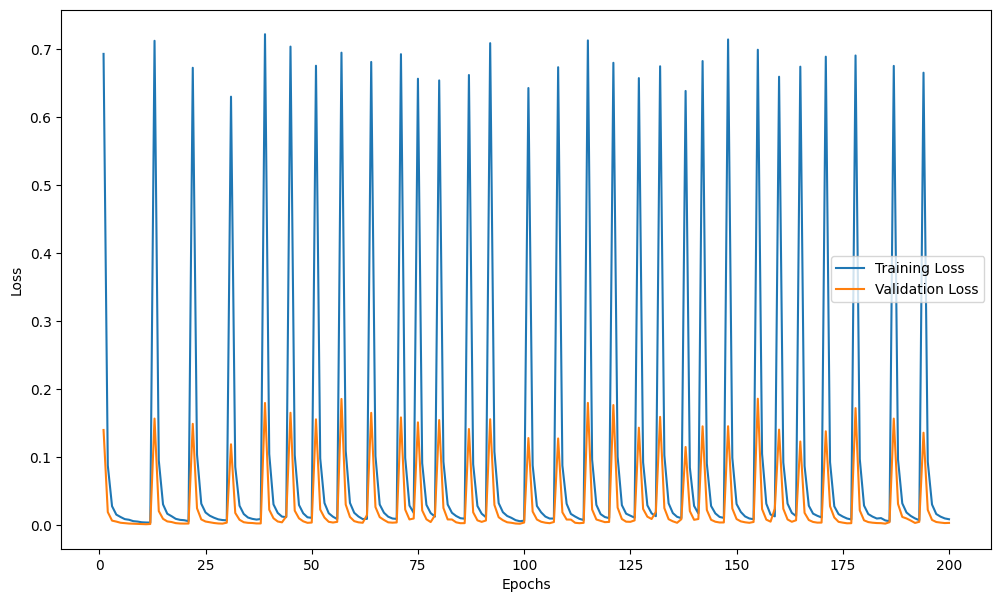

In [43]:
import matplotlib.pyplot as plt

train_losses = history_bert['seed0/fold9']['train_loss'][0]
val_losses = history_bert['seed0/fold9']['val_loss'][0]

plt.figure(figsize=(12, 7))

# Plot training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.title(f'Training and Validation Loss for Round {round_number}')
plt.legend()

# Save the plot
plt.savefig(f'history_bert_01.png')

plt.show()

In [18]:
with open("bert_res_01.txt", 'w') as file:
    for i,item in enumerate(test_report_bert):
        file.write(f"Experiment {i+1}:\n {item}\n\n")

In [19]:
with open("history_bert_01.txt", 'w') as file:
    for i,item in enumerate(history_bert.items()):
        file.write(f"Fold {i+1}:\n {item}\n\n")